# Integrantes:

* Juan Davido Gonzalez 
* Juan Sebastian Montoya

In [1]:
# clonamos el repositorio de Git para tener acceso a todos los archivos usados en el código
!git clone https://github.com/JuanSMontoyaF/ProcesamientoDatosSecuenciales.git

Cloning into 'ProcesamientoDatosSecuenciales'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 149 (delta 0), reused 0 (delta 0), pack-reused 147
Receiving objects: 100% (149/149), 1.66 MiB | 27.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# Espectograma
A continuación se documenta el proceso de visualización de los datos y entrenamiento del modelo basado en convolución 2D pasandole como entrada imágenes del espectograma

## Visualización de los datos

In [2]:
#Importamos las librerias necesarias
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
import librosa
import librosa.display
from IPython import display

In [3]:
#esta función carga un archivo de audio en formato WAV, lo decodifica y 
#realiza algunas transformaciones en los datos, como convertirlo a un solo 
#canal (mono) y eliminar una dimensión redundante. Finalmente, devuelve los 
#datos de audio procesados en forma de tensor.

def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav

(16000,)


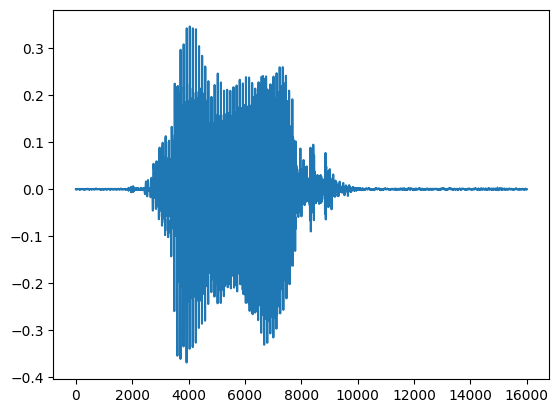

In [5]:
# este código carga un archivo de audio, imprime la forma del tensor de audio 
#y muestra un gráfico de la forma de onda del audio

RutaFile="/content/ProcesamientoDatosSecuenciales/Entrega #1/Audios/nadar3.wav"
wave = load_wav_16k_mono(RutaFile)
print(wave.shape)
plt.plot(wave)
plt.show()

In [6]:
#la función preprocess toma un tensor de audio y realiza un preprocesamiento 
#que incluye el recorte del audio a 1 segundo, el cálculo del espectrograma y 
#la obtención de la magnitud del espectro. Luego, devuelve el espectrograma 
#resultante como un tensor
def preprocess(wave): 
    wav = wave[:16000]
    spectrogram = tf.signal.stft(wav, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [7]:
#este código realiza el preprocesamiento del audio, imprime la forma del tensor 
#de audio y la forma del espectrograma resultante, y reproduce el audio para escucharlo.
espectrograma= preprocess(wave)
print('Waveform shape:', wave.shape)
print('Spectrogram shape:', espectrograma.shape)
print('Audio playback')
display.display(display.Audio(wave, rate=16000))

Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


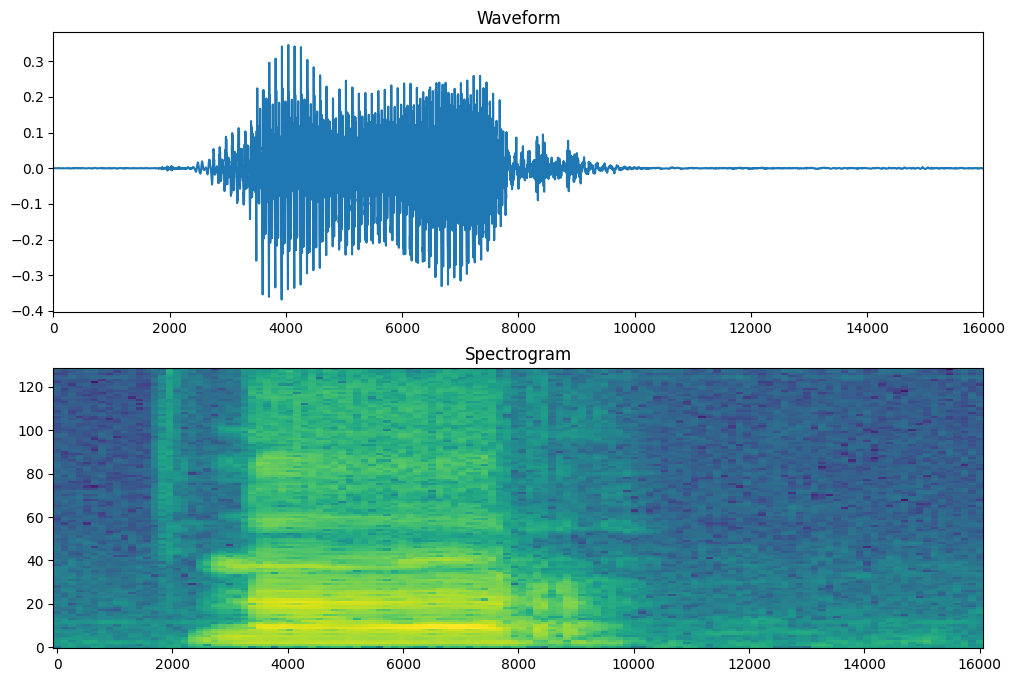

In [8]:
#este código genera una figura de Matplotlib con dos subplots: uno muestra la forma 
#de onda del audio y el otro muestra el espectrograma del audio.
def plot_spectrogram(espectrograma, ax):
  log_spec = np.log(espectrograma.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wave.shape[0])
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(espectrograma.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

## Procesamiento de las imágenes del espectograma

In [9]:
#esta función carga una imagen de un archivo utilizando OpenCV y la redimensiona 
#a un tamaño específico. Luego, devuelve la imagen redimensionada.

def load_and_resize_image(img_file, width, height):
    img = cv2.imread(img_file)
    img = cv2.resize(img, (width, height))
    return img

In [10]:
#Esta función recorre un directorio de imágenes organizadas en carpetas etiquetadas, 
#carga y redimensiona las imágenes, y crea arreglos NumPy de las imágenes y las 
#etiquetas correspondientes. Luego, devuelve los arreglos de imágenes y etiquetas 
#para su uso en un modelo de aprendizaje automático.
def process_data(width, height, label_dict: dict, path_imgs):
    X = []
    Y = []
    
    labels = os.listdir(path_imgs)
    for index, label in enumerate(labels):
        label_dir = os.path.join(path_imgs, label)
        images = glob(os.path.join(label_dir, '*.png'))
        
        for img_file in tqdm(images):
            img = load_and_resize_image(img_file, width, height)
            x = np.array(img, dtype=np.float16)
            y = np.array(label_dict[label], dtype=np.uint8)
            
            X.append(x)
            Y.append(y)
            
    X = np.stack(X)
    Y = np.array(Y).reshape(-1, 1)  
    return X, Y

## Función para el entrenamiento del modelo

In [11]:
#esta función define y entrena un modelo CNN utilizando los datos de entrenamiento y prueba proporcionados. 
#El modelo se compila con una configuración específica y se entrena utilizando los datos de entrenamiento 
#durante un número determinado de épocas. El modelo entrenado y el historial de entrenamiento se devuelven como resultado.

def train_model(X_train, Y_train, X_test, Y_test, num_classes, epochs=20, batch_size=32):
    # Definir la arquitectura del modelo CNN
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compilar el modelo
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size)
    return model, history

In [12]:
#esta función carga, redimensiona y normaliza una imagen, la pasa a través de un modelo 
#previamente entrenado y devuelve la etiqueta predicha para la imagen.

def predict_image(model, img_file, width, height):
    img = load_and_resize_image(img_file, width, height)
    x = np.array([img], dtype=np.float16)
    x = x / 255.0
    prediction = model.predict(x)
    predicted_label = np.argmax(prediction)
    return predicted_label

DATA_DIR_ESPECTRO = '/content/ProcesamientoDatosSecuenciales/Entrega #1/Espectograma'

In [13]:
# este código devuelve una lista de subdirectorios presentes dentro del directorio especificado por DATA_DIR_ESPECTRO
subdirs = next(os.walk(DATA_DIR_ESPECTRO))[1]

In [14]:
#Este código crea un diccionario en el que los subdirectorios se utilizan como claves 
#y se les asignan valores numéricos consecutivos. Esto puede ser útil para asociar 
#etiquetas numéricas a categorías o clases representadas por los subdirectorios.
label_dict = {}
for idx, subdir in enumerate(subdirs):
    label_dict[subdir] = idx
print(label_dict)

{'Trepar': 0, 'Caminar': 1, 'Correr': 2, 'Nadar': 3, 'Saltar': 4}


In [15]:
#Este código procesa los datos de imágenes en los subdirectorios del directorio especificado, 
#asigna etiquetas numéricas a las imágenes, y normaliza los datos dividiendo por 255.0 para 
#prepararlos para su uso en un modelo de aprendizaje automático.
X_espectro, Y_espectro = process_data(224, 224, label_dict, DATA_DIR_ESPECTRO)
X_espectro = X_espectro / 255.0

100%|██████████| 8/8 [00:00<00:00, 270.07it/s]


In [16]:
# este código divide los datos de imágenes y etiquetas en conjuntos de entrenamiento y 
#prueba utilizando una proporción específica (20% para pruebas) y una semilla aleatoria para garantizar 
#la reproducibilidad de la división de los datos. Los conjuntos de entrenamiento y prueba se asignan a 
#las variables correspondientes para su posterior uso en el entrenamiento y evaluación de un modelo de aprendizaje automático.

X_train_epc, X_test_epc, Y_train_epc, Y_test_epc = train_test_split(X_espectro, Y_espectro, test_size=0.2, random_state=42)

## Entrenamiento del modelo

In [48]:
#Este código entrena un modelo de aprendizaje automático utilizando los conjuntos de datos de entrenamiento 
#y prueba, y devuelve el modelo entrenado y el historial de entrenamiento para su posterior análisis y evaluación.
model, history = train_model(X_train_epc, Y_train_epc, X_test_epc, Y_test_epc, num_classes=len(label_dict))

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 1.6125 - accuracy: 0.2188 - val_loss: 2.5146 - val_accuracy: 0.1250
Epoch 2/20
1/1 [==============================] - 0s 97ms/step - loss: 2.1406 - accuracy: 0.2812 - val_loss: 2.1312 - val_accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 0s 85ms/step - loss: 2.6313 - accuracy: 0.1875 - val_loss: 2.0945 - val_accuracy: 0.3750
Epoch 4/20
1/1 [==============================] - 0s 86ms/step - loss: 2.3110 - accuracy: 0.3750 - val_loss: 1.5668 - val_accuracy: 0.3750
Epoch 5/20
1/1 [==============================] - 0s 86ms/step - loss: 1.3845 - accuracy: 0.5625 - val_loss: 1.4334 - val_accuracy: 0.2500
Epoch 6/20
1/1 [==============================] - 0s 77ms/step - loss: 1.0606 - accuracy: 0.9062 - val_loss: 1.4974 - val_accuracy: 0.2500
Epoch 7/20
1/1 [==============================] - 0s 83ms/step - loss: 0.9881 - accuracy: 0.6875 - val_loss: 1.4001 - val_accuracy: 0.2500
Epoch 8/20
1/1 [=============

## Gráficas

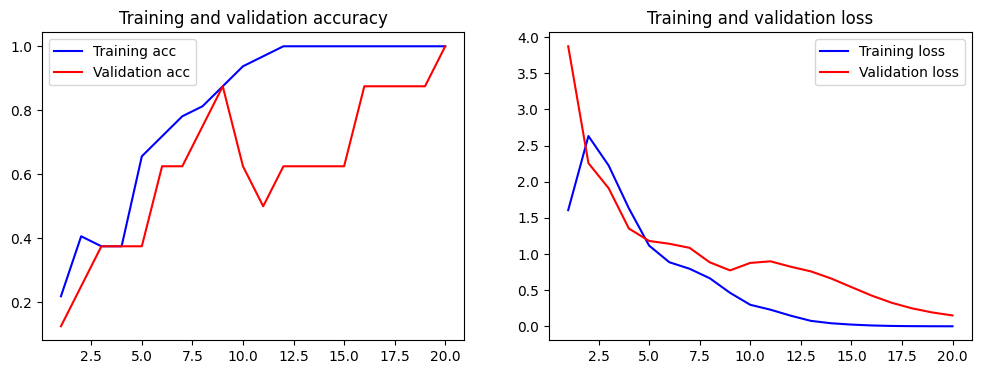

In [18]:
#este código genera gráficas que muestran la evolución de la precisión y la pérdida 
#tanto en el conjunto de entrenamiento como en el conjunto de validación a lo largo 
#de las épocas durante el entrenamiento del modelo. Esto permite evaluar el rendimiento 
#y la convergencia del modelo durante el proceso de entrenamiento.

def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

plot_training_results(history)

## Predicción

In [19]:
#Orden de las clases
#{'Trepar': 0, 'Caminar': 1, 'Correr': 2, 'Nadar': 3, 'Saltar': 4}

In [21]:
#Realizar predicción con una imagen de espectrograma
test_img = "/content/ProcesamientoDatosSecuenciales/Entrega #1/Espectograma/Nadar/nadar3.png"
predicted_label = predict_image(model, test_img, 224, 224)
print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 446ms/step
Predicted label: 3


In [22]:
#Guardamos el modelo
model.save('modelo_espectrograma.h5')

# MFCC

## Visualización de los datos

In [23]:
#Este código carga un archivo de audio en formato WAV, decodifica su contenido para 
#obtener la forma de onda de audio y devuelve la forma de onda como resultado.

def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav

In [24]:
#este código realiza el cálculo de los coeficientes MFCC a partir de una 
#forma de onda de audio utilizando la biblioteca librosa y devuelve 
#los MFCC como resultado del preprocesamiento.

def preprocess(wave):
    wave = wave.numpy()
    # Calcula los MFCC
    mfccs = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=13)
    return mfccs

(16000,)


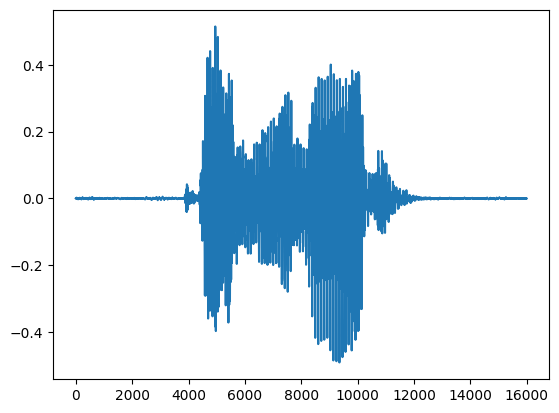

In [27]:
#Este código carga un archivo de audio WAV, muestra la forma de onda de audio 
#y su forma (tamaño), y luego muestra el gráfico de la forma de onda utilizando 
#la biblioteca Matplotlib.

RutaFile="/content/ProcesamientoDatosSecuenciales/Entrega #1/Audios/caminar3.wav"
wave = load_wav_16k_mono(RutaFile)
print(wave.shape)
plt.plot(wave)
plt.show()

In [28]:
#Este código realiza el procesamiento de la forma de onda de audio para obtener 
#los coeficientes MFCC, imprime la forma de la forma de onda y los coeficientes 
#MFCC, y muestra un reproductor de audio para reproducir la forma de onda de audio.

espectrograma = preprocess(wave)
print('Waveform shape:', wave.shape)
print('MFCC shape:', espectrograma.shape)
print('Audio playback')
display.display(display.Audio(wave, rate=16000))

Waveform shape: (16000,)
MFCC shape: (13, 32)
Audio playback


In [29]:
#Esta función toma los coeficientes MFCC y los muestra como un espectrograma utilizando 
#la biblioteca librosa. El espectrograma se representa en los ejes especificados y se le asigna el título "MFCC".

def plot_mfcc(mfcc, ax):
    librosa.display.specshow(mfcc, x_axis='time', ax=ax)
    ax.set(title='MFCC')

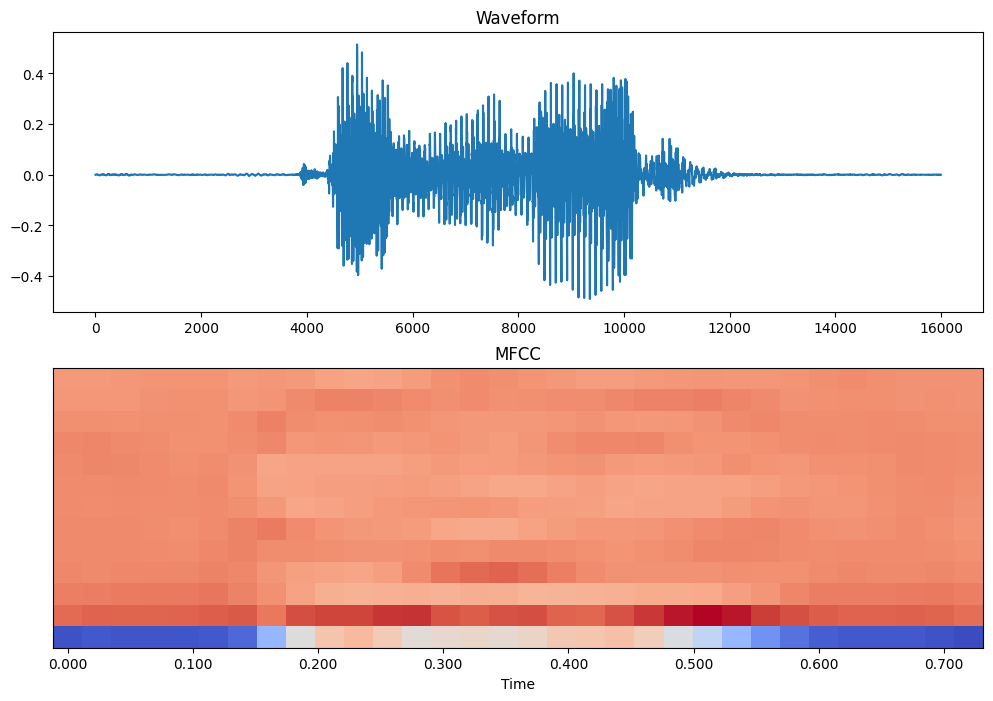

In [30]:
#Este código crea una figura con dos subplots, muestra la forma de onda de audio en el 
#primer subplot y el espectrograma de los coeficientes MFCC en el segundo subplot. 
#Los subplots tienen títulos correspondientes y se muestran en una ventana emergente utilizando plt.show().

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wave.shape[0])
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
plot_mfcc(espectrograma, axes[1])
axes[1].set_title('MFCC')
plt.show()

In [33]:
DATA_DIR_MFCC = '/content/ProcesamientoDatosSecuenciales/Entrega #1/MFCC'

In [34]:
subdirs = next(os.walk(DATA_DIR_MFCC))[1]

In [49]:
#La función process_data procesa los archivos de imagen en el directorio especificado, 
#los carga, los redimensiona a las dimensiones deseadas y los almacena en la variable 
#X_mfcc. Las etiquetas correspondientes se almacenan en la variable Y_mfcc. 
#Los datos se preparan para su uso en el entrenamiento de un modelo de aprendizaje automático.

# Crear diccionario de etiquetas
label_dict_mfcc = {subdir: idx for idx, subdir in enumerate(subdirs)}
# Imprimir diccionario resultante
print(label_dict_mfcc)

{'Trepar': 0, 'Caminar': 1, 'Correr': 2, 'Nadar': 3, 'Saltar': 4}


In [50]:
X_mfcc, Y_mfcc = process_data(224, 224, label_dict_mfcc, DATA_DIR_MFCC)

100%|██████████| 8/8 [00:00<00:00, 194.63it/s]


In [37]:
X_train_mfcc, X_test_mfcc, Y_train_mfcc, Y_test_mfcc = train_test_split(X_mfcc, Y_mfcc, test_size=0.2, random_state=42)

## Función para el entrenamiento del modelo

In [51]:
#Este código define un modelo de aprendizaje automático con capas de convolución, agrupación máxima, 
#aplanamiento y capas densas para procesar los coeficientes MFCC y realizar la clasificación de 
#acuerdo con las clases definidas en label_dict.

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train_mfcc[0].shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_dict), activation='softmax')
])

In [39]:
# Compilar el modelo
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Entrenamiento del modelo

In [40]:
#Entrenamiento del modelo
history2 = model2.fit(X_train_mfcc, Y_train_mfcc, validation_data=(X_test_mfcc, Y_test_mfcc), epochs=30, batch_size=32)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 28.7350 - accuracy: 0.1875 - val_loss: 1501.8674 - val_accuracy: 0.1250
Epoch 2/30
1/1 [==============================] - 0s 105ms/step - loss: 1243.1562 - accuracy: 0.2188 - val_loss: 451.7375 - val_accuracy: 0.1250
Epoch 3/30
1/1 [==============================] - 0s 77ms/step - loss: 354.8636 - accuracy: 0.2188 - val_loss: 231.2245 - val_accuracy: 0.2500
Epoch 4/30
1/1 [==============================] - 0s 83ms/step - loss: 219.2437 - accuracy: 0.1875 - val_loss: 183.4906 - val_accuracy: 0.2500
Epoch 5/30
1/1 [==============================] - 0s 91ms/step - loss: 178.0701 - accuracy: 0.1875 - val_loss: 88.3989 - val_accuracy: 0.2500
Epoch 6/30
1/1 [==============================] - 0s 77ms/step - loss: 80.5897 - accuracy: 0.1875 - val_loss: 48.8924 - val_accuracy: 0.1250
Epoch 7/30
1/1 [==============================] - 0s 82ms/step - loss: 36.4883 - accuracy: 0.2188 - val_loss: 49.3430 - val_accuracy: 0.1250
Epoc

## Gráficas

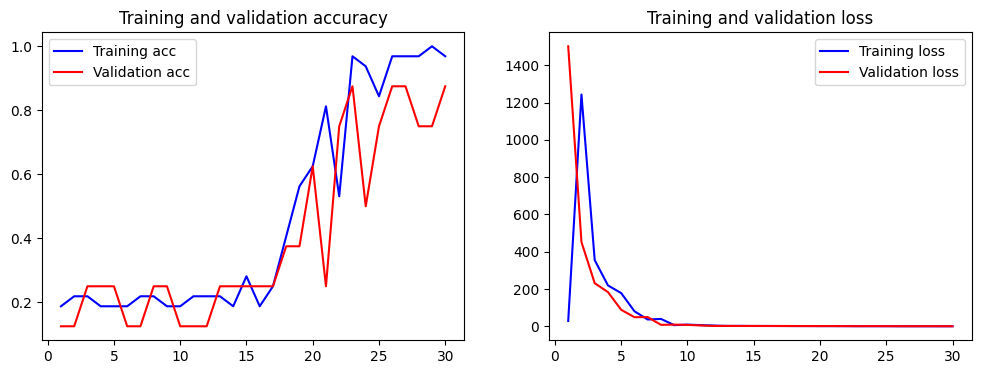

In [41]:
#Gráficas para el comportamiento del modelo
def plot_training_results(history2):
    acc2 = history2.history['accuracy']
    val_acc2 = history2.history['val_accuracy']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']
    
    epochs = range(1, len(acc2) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc2, 'b', label='Training acc')
    plt.plot(epochs, val_acc2, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss2, 'b', label='Training loss')
    plt.plot(epochs, val_loss2, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

plot_training_results(history2)

## Predicción

In [ ]:
#{'Trepar': 0, 'Nadar': 1, 'Saltar': 2, 'Correr': 3, 'Caminar': 4}

In [46]:
#El código carga una imagen, la redimensiona, la convierte en un formato adecuado 
#para el modelo, realiza la predicción utilizando el modelo entrenado y muestra la 
#etiqueta de clase predicha.

import cv2
import numpy as np

# Leer la imagen
mfcc_image = cv2.imread('/content/ProcesamientoDatosSecuenciales/Entrega #1/MFCC/Correr/correr4.png')

# Redimensionar la imagen
new_size = (224, 224)  
resized_image = cv2.resize(mfcc_image, new_size)

# Convertir la imagen a tipo de datos float16
resized_image = np.array(resized_image, dtype=np.float16)

# Añadir una dimensión adicional a la imagen
resized_image = np.expand_dims(resized_image, axis=0)

# Realizar la predicción utilizando el modelo 
prediction = model2.predict(resized_image)

# Obtener la etiqueta predicha
predicted_label = np.argmax(prediction)

# Obtener la clase predicha a partir del diccionario de etiquetas 
predicted_class = list(label_dict_mfcc.keys())[predicted_label]

# Imprimir la predicción
print('Predicción:', predicted_class)


1/1 [==============================] - 0s 20ms/step
Predicción: Correr


In [45]:
#Se guarda el modelo de MFCC
model2.save('modelo_MFCC.h5')